In [6]:
import math
import random
from functools import lru_cache
from pathlib import Path

import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

# Truck Trajectory Image

In [7]:
image_top_down = cv2.imread("../assets/images/Camera_TopDown_ImageRGB_blank.png")
image_truck_trajectories = Path("../assets/images/Camera_TopDown_Truck_Trajectories.png")

# set this to a path containing the fully rendered MOT dataset like "complex-logistics-yard-truck-scene_MOT_wo_Duplicates/mot_dataset"
MOT_DATASET_PATH = Path("/home/tom/Downloads/complex-logistics-yard-truck-scene_MOT_wo_Duplicates/mot_dataset")

In [8]:
# parse all MOT files of the cameras
mot_files = {}

for camera_name in ["Camera_TopDown"]:
    mot_files[camera_name] = {}
    with open(MOT_DATASET_PATH / camera_name / "gt/gt.txt") as f:
        for line in f.readlines():
            line = line.strip()
            if line == "":
                continue
            line = line.split(",")
            frame = int(line[0])
            id = int(line[1])
            x = float(line[2])
            y = float(line[3])
            w = float(line[4])
            h = float(line[5])
            mot_files[camera_name][frame] = mot_files[camera_name].get(frame, []) + [(id, x, y, w, h)]

100%|██████████| 1500/1500 [00:00<00:00, 337072.38it/s]


Saved image to /home/tom/git/fraunhofer/SynthDataMCMOT/notebooks/../assets/images/Camera_TopDown_Truck_Trajectories.png


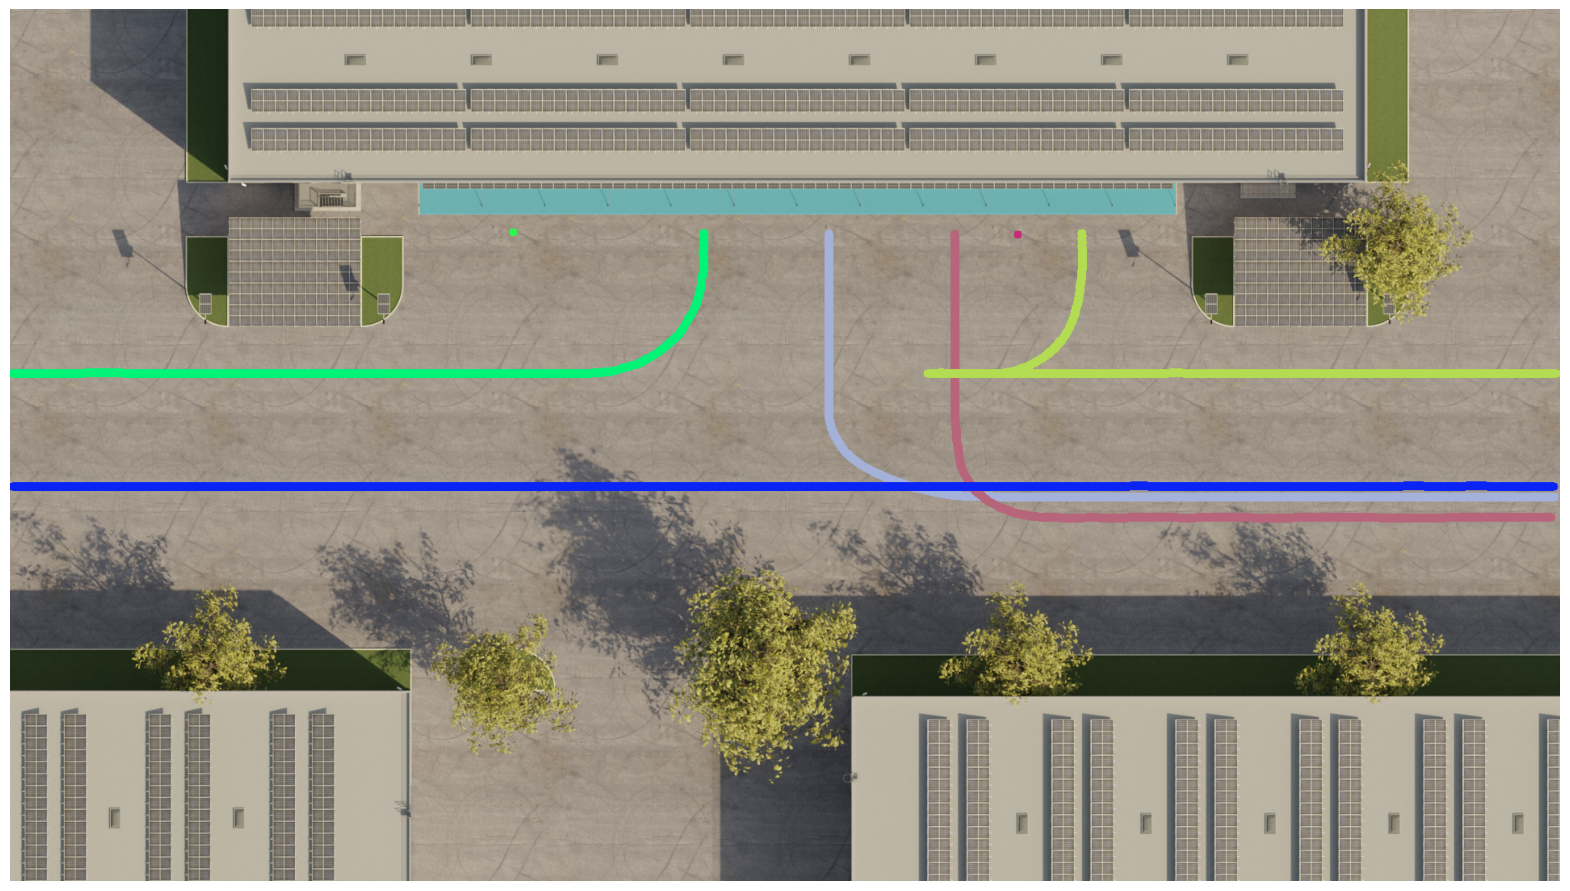

In [15]:
@lru_cache
def name_to_color(name: str) -> tuple[int, int, int]:
    """Convert a string to a random deterministic color.

    Uses a new random object instance to avoid messing with the global random state.

    Args:
        name (str): The string to convert

    Returns:
        Tuple[int, int, int]: A tuple of three integers representing the RGB color values (0-255)
    """
    rnd = random.Random(name)
    return (rnd.randint(0, 255), rnd.randint(0, 255), rnd.randint(0, 255))


def plot_frame():

    first_frame = 0
    last_frame = 1500

    # id -> (points, color)
    polylines: dict(tuple(list, tuple(int, int, int))) = {}

    for frame_number in tqdm(range(first_frame, last_frame)):
        if frame_number in mot_files["Camera_TopDown"]:
            for id, x, y, w, h in mot_files["Camera_TopDown"][frame_number]:
                mid_x = x + w / 2
                mid_y = y + h / 2
                if id not in polylines:
                    color = name_to_color(f"Truck_{id}")
                    polylines[id] = ([(mid_x, mid_y)], color)
                else:
                    polylines[id][0].append((mid_x, mid_y))


    image = image_top_down.copy()

    for id, (points, color) in polylines.items():
        # downsample points to 25%
        points = points[::4]
        points = np.array(points, np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.polylines(image, [points], False, color, 10)
        

    # save the final image
    cv2.imwrite(str(image_truck_trajectories.absolute()), image)
    print(f"Saved image to {image_truck_trajectories.absolute()}")

    # display the final image in the notebook
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    plt.show()
    

plot_frame()